In [2]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_error
from scipy.optimize import curve_fit

# Graphing
from graph_config import plt
import seaborn as sns

import tqdm as tqdm

from pathlib import Path
import sys

NOTEBOOK_PATH = Path(__file__).resolve() if '__file__' in globals() else Path().resolve()

PROJECT_ROOT = NOTEBOOK_PATH.parent

# Define path to the dataset folder
RAW_DATASET_PATH = PROJECT_ROOT / '01_datasets'/'raw'
PROCESSED_DATASET_PATH = PROJECT_ROOT / '01_datasets'/'processed'

# Define path to output folder
FIGURES_PATH = PROJECT_ROOT / '04_outputs' / '01_figures'
TABLES_PATH = PROJECT_ROOT / '04_outputs' / '02_tables'

# Script paths
SCRIPTS_PATH = PROJECT_ROOT / '03_scripts'


In [3]:
def load_data(filename):
    return pd.read_csv(RAW_DATASET_PATH / filename)

df_tt_og = load_data('Turbine_telemetry.csv')
# df_rd = load_data('Residential_demand.csv')
# df_wd = load_data('kirkwall_weather.csv')

df_tt_og['Timestamp'] = pd.to_datetime(df_tt_og['Timestamp'])

df_tt = df_tt_og.copy()

# Cleaning

## Setting Power to NaN when wind speed is fast enough

In [4]:
# Find the minimum wind speed for power production

v_cut_in = df_tt[(df_tt.loc[:, 'Power_kw'] >= 10.)].loc[:, 'Wind_ms'].quantile(0.1) # 10% quantile minimum speed
v_cut_out = df_tt[df_tt['Power_kw'] >= 10]['Wind_ms'].quantile(0.95)

print(f"minimum wind speed for power production: {v_cut_in:.2f} m/s")
print(f"maximum wind speed for power production: {v_cut_out:.2f} m/s")

# remove data points when the wind speed is fast enough for power production but there is no power; turbine is probably manually switched off here
df_tt.loc[
    (df_tt['Wind_ms'] >= v_cut_in) & 
    (df_tt['Power_kw'].abs() <= 1e-5) &
    (df_tt['Setpoint_kw'] > 0),
    'Power_kw'
] = np.nan

df_tt[df_tt.isna().any(axis=1)]

# Column Settings
# df_tt['Timestamp'] = pd.to_datetime(df_tt['Timestamp'])
# df_tt['Date'] = df_tt['Timestamp'].dt.date
# df_tt['Time'] = df_tt['Timestamp'].dt.time
# df_tt['Month'] = df_tt['Timestamp'].dt.month

# Clip the power to the setpoint 900 kW
df_tt['Power_kw'] = df_tt['Power_kw'].clip(upper=900)

print(f"turbine telemetry data shape: {df_tt.shape}")

df_tt.head()

minimum wind speed for power production: 5.00 m/s
maximum wind speed for power production: 20.70 m/s
turbine telemetry data shape: (1069636, 4)


,Timestamp,Power_kw,Setpoint_kw,Wind_ms
0,2015-05-28 00:00:23,80.0,900.0,4.9
1,2015-05-28 00:01:23,78.0,900.0,5.4
2,2015-05-28 00:02:23,52.0,900.0,4.9
3,2015-05-28 00:03:23,57.0,900.0,4.6
4,2015-05-28 00:04:23,54.0,900.0,4.6


## Convert to Timeseries For Resampling

In [5]:
ts_tt = df_tt.set_index('Timestamp')
ts_tt = ts_tt.sort_index()

ts_tt_res = ts_tt.resample('30min').mean()

ts_tt_res_17 = ts_tt_res[
    (ts_tt_res.index >= '2017-01-01') &
    (ts_tt_res.index < '2018-01-02')
]

ts_tt_res_17.shape

(17568, 3)

# Analysis

# Are there missing value?

In [6]:
pd.DataFrame(ts_tt_res_17.isna().sum()).rename({0: 'Count'}, axis=1).T


,Power_kw,Setpoint_kw,Wind_ms
Count,1046,1012,1012


---

## Why Wind has less missing value?

In [7]:
# power is na but wind is not
ts_tt_res_17[(ts_tt_res_17['Power_kw'].isna()) & (ts_tt_res_17['Wind_ms'].notna())].head()

,Power_kw,Setpoint_kw,Wind_ms
Timestamp,,,
2017-01-12 18:00:00,NaN,900.0,23.556667
2017-01-12 19:00:00,NaN,900.0,23.820000
2017-01-12 19:30:00,NaN,900.0,26.503333
2017-01-12 20:00:00,NaN,900.0,25.410000
2017-01-12 21:30:00,NaN,900.0,25.470000


we set power to NaN when wind is high and setpoint is set to 900 that is why there is more NaN value for power. This logic need to be maintain when doing interpolation or filling missing value with scraped wind data

---

## Check Longest Consecutive NaN Value

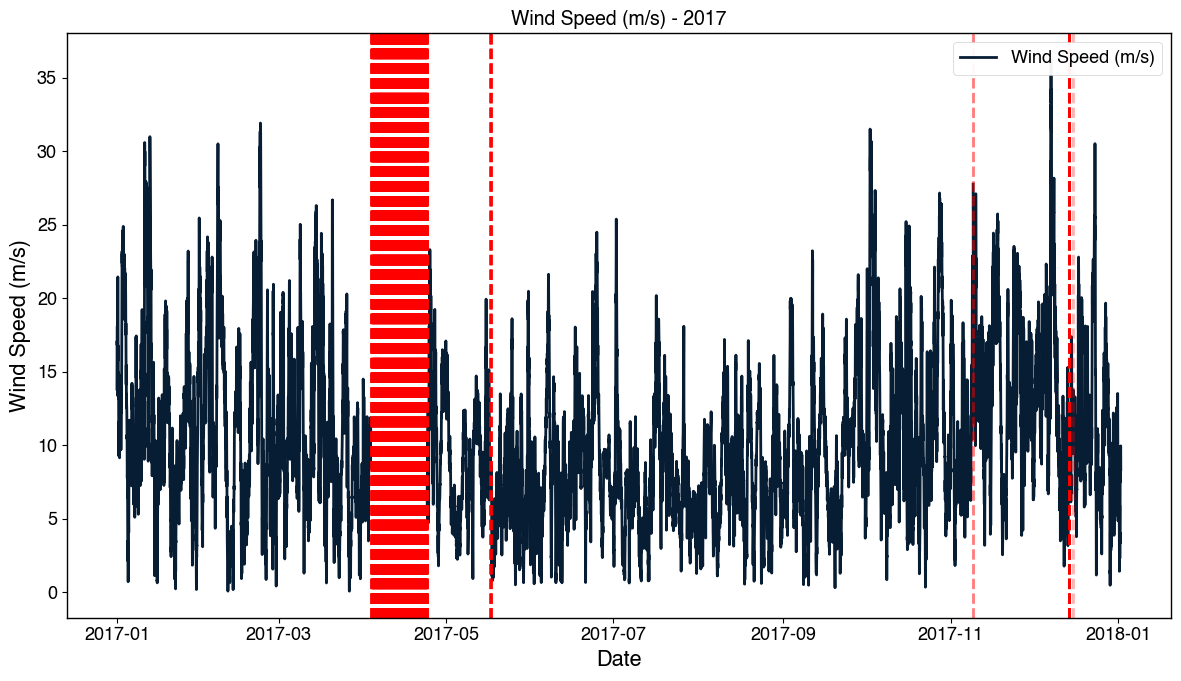

In [8]:
is_nan = ts_tt_res_17['Wind_ms'].isna()

plt.figure(figsize=(12,7))
plt.plot(ts_tt_res_17.index, ts_tt_res_17['Wind_ms'], label='Wind Speed (m/s)')
for t in ts_tt_res_17.index[is_nan]:
    plt.axvline(x=t, color='red', linestyle='--', alpha=0.3)
plt.title('Wind Speed (m/s) - 2017')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [9]:
wind_is_nan = ts_tt_res_17['Wind_ms'].isna()

start_mask = is_nan & ~is_nan.shift(1, fill_value=False)
end_mask = is_nan & ~is_nan.shift(-1, fill_value=False)

start_times = ts_tt_res_17.index[start_mask]
end_times = ts_tt_res_17.index[end_mask]

nan_ranges_df = pd.DataFrame({
    'Start': start_times,
    'End': end_times
})

nan_ranges_df['Duration'] = nan_ranges_df['End'] - nan_ranges_df['Start']

nan_ranges_df.head(50)

,Start,End,Duration
0,2017-04-03 15:30:00,2017-04-24 02:30:00,20 days 11:00:00
1,2017-05-17 02:30:00,2017-05-17 08:00:00,0 days 05:30:00
2,2017-11-09 02:30:00,2017-11-09 03:00:00,0 days 00:30:00
3,2017-12-13 22:30:00,2017-12-14 05:00:00,0 days 06:30:00
4,2017-12-15 13:00:00,2017-12-15 13:00:00,0 days 00:00:00


The longest missing value in 2017 is on April 03 15:30 until April 24 02:30 that last for 20 days and 11 hours.  Then on May 17 from 02:30 until 08:00 there is missing value that last for 5 hourss 30 minute. 

---

# Check Scraped-Baseline Wind data

In [10]:
# Import the scraped weather data
df_wd = load_data(PROCESSED_DATASET_PATH/'df_wd_resampled.csv')

print(f"weather shape: {df_wd.shape}")


df_wd['Timestamp'] = pd.to_datetime(df_wd['Timestamp'])
ts_wd = df_wd.set_index('Timestamp').copy()

ts_wd.head()

weather shape: (17568, 6)


,Temperature (F),Wind Speed (m/s),Humidity (%),Pressure (Hg),Visibility (mi)
Timestamp,,,,,
2017-01-01 00:30:00,41.0,10.28,81.0,30.04,NaN
2017-01-01 01:00:00,43.0,9.39,81.0,30.04,NaN
2017-01-01 01:30:00,41.0,9.83,87.0,30.04,NaN
2017-01-01 02:00:00,39.0,7.15,87.0,30.07,5.0
2017-01-01 02:30:00,41.0,8.94,76.0,30.07,NaN


---

### Are there similar timestamp where wind is NaN

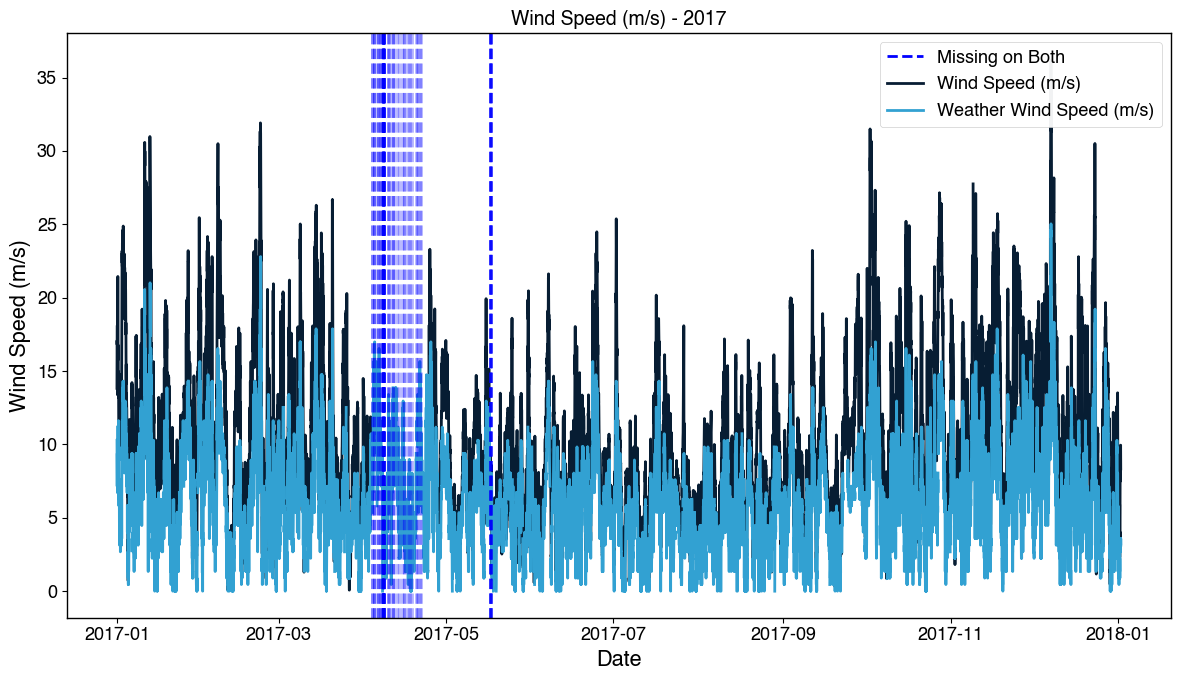

In [11]:
import matplotlib.lines as mlines

common_index = ts_wd.index.intersection(ts_tt_res_17.index)

df1 = ts_wd.loc[common_index]
df2 = ts_tt_res_17.loc[common_index]

# Step 3: Find timestamps where both have NaN in Wind_ms
both_nan_mask = df1['Wind Speed (m/s)'].isna() & df2['Wind_ms'].isna()

# Step 4: Extract those timestamps into a DataFrame
shared_nan_df = pd.DataFrame({'Timestamp': common_index[both_nan_mask]})

#plot shared NaN timestamps
plt.figure(figsize=(12,7))
# Draw vertical lines for missing data
plt.plot(ts_tt_res_17.index, ts_tt_res_17['Wind_ms'], label='Wind Speed (m/s)')
plt.plot(ts_wd.index, ts_wd['Wind Speed (m/s)'], label='Weather Wind Speed (m/s)')
for t in shared_nan_df['Timestamp']:
    plt.axvline(x=t, color='blue', linestyle='--', alpha=0.3)

blue_line = mlines.Line2D([], [], color='blue', linestyle='--', label='Missing on Both')
plt.title('Wind Speed (m/s) - 2017')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.legend(handles=[blue_line] + plt.gca().lines[:2])  # legend for lines + dummy markers
plt.grid()
plt.tight_layout()
plt.show()

In [12]:
print(f"Number of shared NaN timestamps: {len(shared_nan_df)}")

ts_tt_res_17.loc[shared_nan_df['Timestamp'], 'Wind_ms'].head()

Number of shared NaN timestamps: 65


Timestamp
2017-04-03 21:30:00   NaN
2017-04-04 03:00:00   NaN
2017-04-04 13:30:00   NaN
2017-04-04 14:30:00   NaN
2017-04-04 18:30:00   NaN
Name: Wind_ms, dtype: float64



There are 65 timestamps where both the scraped and baseline data doesnt have a data. 

---

# Deriving Power Curve 

To derive the power curve using the baseline wind speed and power output we will use a derivation of weibull distribution model to measure the distribution. 


$$
P(\nu) = P_r \left(1 - e^{- \left(\frac{\nu - v_0}{c}\right)^3} \right)
$$

Where:

* $\nu$ = wind speed
* $v_0$ = minimum wind speed (`v_min`)
* $c$ = scale parameter
* $P_r$ = rated power

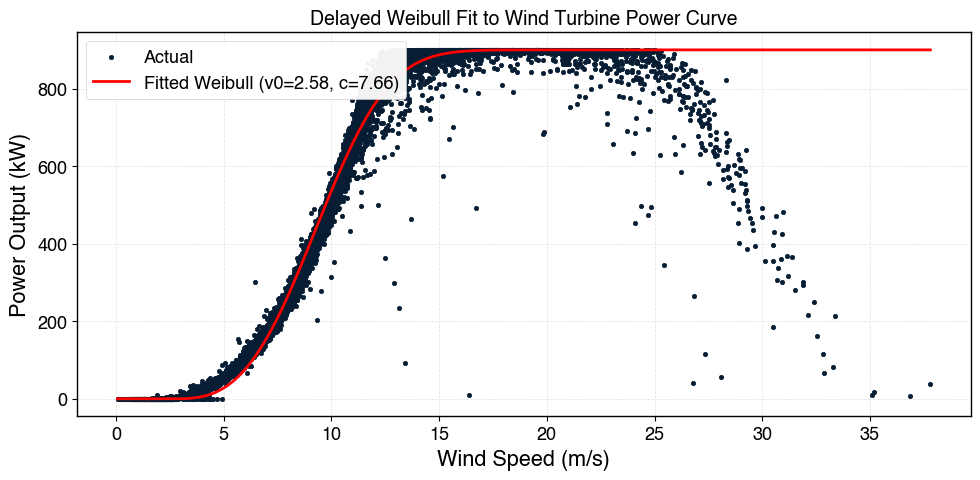

(np.float64(2.583001279343198), np.float64(7.664525045028845))

In [13]:
def delayed_weibull(v:float, v0:float, c:float, pr:float):
    """
    Weibull model for wind speed distribution.
    
    Parameters:
    pr (float): Power rating of the turbine in kW. (or setpoint in our case i think)
    v (float): Wind speed in m/s.
    v0 (float): Scale parameter of the Weibull distribution in m/s.
    
    Returns:
    float: Power output in kW.
    """
    v = np.asarray(v)
    power = np.zeros_like(v)
    mask = v > v0
    power[mask] = pr * (1 - np.exp(-((v[mask] - v0) / c) ** 3))
    return power


#remove nan values and convert to values
df_model = load_data(PROCESSED_DATASET_PATH/'power_curve_analysis.csv')
df_model = df_model.dropna(subset=['Wind_speed_baseline', 'Power_baseline'])

# # filter out above 895 wind speed
# df_model = df_model[(df_model['Power_kw'] < 895) & (df_model['Setpoint_kw'] == 900)]

wind = df_model['Wind_speed_baseline'].values
power = df_model['Power_baseline'].values


# Initial guesses for v0 and c
initial_guess = [2.7, 6.5]

# Fit curve
popt, pcov = curve_fit(lambda v, v0, c: delayed_weibull(v, v0, c, pr=900), wind, power, p0=initial_guess)

# Predicted values using fitted parameters
v0_fit, c_fit = popt
predicted_power = delayed_weibull(wind, v0_fit, c_fit, pr=900)

# Plot actual vs fitted curve
v_sorted = np.sort(wind)

predicted_sorted = delayed_weibull(v_sorted, v0_fit, c_fit, pr=900)

plt.figure(figsize=(10, 5))
plt.scatter(wind, power, label='Actual', s=10)
plt.plot(v_sorted, predicted_sorted, color='red', label=f'Fitted Weibull (v0={v0_fit:.2f}, c={c_fit:.2f})')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power Output (kW)')
plt.title('Delayed Weibull Fit to Wind Turbine Power Curve')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

v0_fit, c_fit

Visually the power curve looks like it fit the data generally well. We could check the error metrics to confirm it

---

In [14]:
# Check Score of Fit

df_compare = pd.DataFrame({
    'Wind Speed (m/s)': wind,
    'Power Output (kW)': power,
    'Predicted Power Output (kW)': predicted_power
})
df_compare['Residuals'] = df_compare['Power Output (kW)'] - df_compare['Predicted Power Output (kW)']
df_compare['Residuals'] = df_compare['Residuals'].abs()

r_score = r2_score(df_compare['Power Output (kW)'], df_compare['Predicted Power Output (kW)'])
rmse = root_mean_squared_error(df_compare['Power Output (kW)'], df_compare['Predicted Power Output (kW)'])
mae = mean_absolute_error(df_compare['Power Output (kW)'], df_compare['Predicted Power Output (kW)'])
mse = mean_squared_error(df_compare['Power Output (kW)'], df_compare['Predicted Power Output (kW)'])

df_metrics = pd.DataFrame({
    'Metric': ['R^2', 'RMSE', 'MAE', 'MSE'],
    'Value': [r_score, rmse, mae, mse]
})

df_metrics.head()

,Metric,Value
0,R^2,0.976163
1,RMSE,51.766336
2,MAE,25.017953
3,MSE,2679.753505


The error metrics suggest that the Weibull model fits the wind turbine power curve quite well. The $R^2$ value is 0.976, which means the model explains about 97.6% of the variation in power output. This shows that the model is doing a good job at capturing the relationship between wind speed and power.

The RMSE is 51.77, which gives us an idea of how far off our predictions are from the actual values on average. Since it's in the same units as power, it’s easier to interpret and shows that the errors are fairly small.

The MAE is 25.02, meaning that, on average, the model’s predictions are about 25 units off from the real values. This is quite low, which again suggests the model is performing well. The MSE (Mean Squared Error) is 2679.75, which is just the average of the squared errors and is mainly useful to compare with other models.


---

## Cut In / Cut Out

We can estimate the cut-in and cut-out wind speeds—the wind speeds at which a turbine starts and stops producing power, by looking at the distribution of wind speeds when the turbine is generating power.

In this case, we filtered the data to only include rows where the power output is at least 10 kW, which means we're only considering meaningful power production. Then, we used quantiles to find typical lower and upper bounds for wind speed during power generation

In [15]:
_v_cut_in = df_model[(df_model.loc[:, 'Power_baseline'] >= 10.)].loc[:, 'Wind_speed_baseline'].quantile(0.1) # 5% quantile minimum speed
_v_cut_out = df_model[df_model['Power_baseline'] >= 10]['Wind_speed_baseline'].quantile(0.95)

print(f"minimum wind speed for power production: {_v_cut_in:.2f} m/s")
print(f"maximum wind speed for power production: {_v_cut_out:.2f} m/s")

minimum wind speed for power production: 5.12 m/s
maximum wind speed for power production: 21.25 m/s


we can also visually intrepret the cut in/out speed 

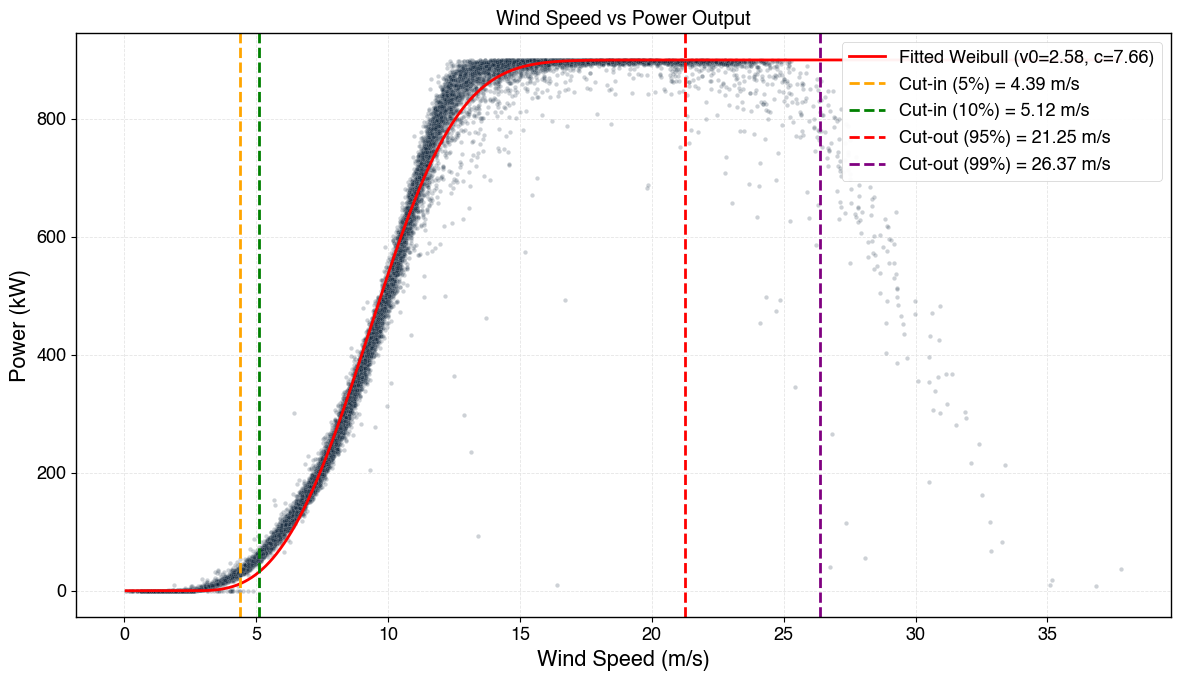

In [16]:
# Filter out rows with missing data
df_plot = df_model.dropna(subset=['Wind_speed_baseline', 'Power_baseline'])

# Compute both quantiles for cut-in and cut-out
cutin_05 = df_plot[df_plot['Power_baseline'] >= 10]['Wind_speed_baseline'].quantile(0.05)
cutin_10 = df_plot[df_plot['Power_baseline'] >= 10]['Wind_speed_baseline'].quantile(0.10)
cutout_95 = df_plot[df_plot['Power_baseline'] >= 10]['Wind_speed_baseline'].quantile(0.95)
cutout_99 = df_plot[df_plot['Power_baseline'] >= 10]['Wind_speed_baseline'].quantile(0.99)

# Create scatter plot
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df_plot, x='Wind_speed_baseline', y='Power_baseline', alpha=0.2, s=10)
plt.plot(v_sorted, predicted_sorted, color='red', label=f'Fitted Weibull (v0={v0_fit:.2f}, c={c_fit:.2f})')

# Draw cut-in / cut-out lines
plt.axvline(cutin_05, color='orange', linestyle='--', label=f'Cut-in (5%) = {cutin_05:.2f} m/s')
plt.axvline(cutin_10, color='green', linestyle='--', label=f'Cut-in (10%) = {cutin_10:.2f} m/s')
plt.axvline(cutout_95, color='red', linestyle='--', label=f'Cut-out (95%) = {cutout_95:.2f} m/s')
plt.axvline(cutout_99, color='purple', linestyle='--', label=f'Cut-out (99%) = {cutout_99:.2f} m/s')

# Labels and legend
plt.title('Wind Speed vs Power Output')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (kW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We use quantiles to estimate the typical operating range of the turbine:

* The cut-in speed is the minimum wind speed where the turbine starts generating a noticeable amount of power. From the plot, the 5th percentile is around 4.39 m/s (orange dashed line), and the 10th percentile is about 5.12 m/s (green dashed line). These lines mark where power output begins to ramp up.

* The cut-out speed is the wind speed beyond which power output drops or flattens—either due to turbine shutoff (for safety) or limits in capacity. The 95th percentile is around 21.25 m/s (red dashed line), and the 99th percentile is 26.37 m/s (purple dashed line). These values show where the turbine is likely to stop increasing or even cut back production.

this correlate with typical wind turbine control system


[Wikipedia Source](https://en.wikipedia.org/wiki/Wind_turbine_design#:~:text=A%20wind%20turbine%20must%20produce,power%20has%20to%20be%20limited.)

---

# Filling NaN Wind Speed Data

We're going to left join the turbine data with the scraped weather data. 

In [17]:
ts_combined_2017 = ts_tt_res_17.merge(
    ts_wd['Wind Speed (m/s)'],
    left_index=True,
    right_index=True,
    how='left'
)

ts_combined_2017.rename(
    columns={
        'Wind Speed (m/s)': 'Scrape_wind_ms',
        'Wind_ms': 'Baseline_wind_ms'},
    inplace=True
)

ts_combined_2017.head()

,Power_kw,Setpoint_kw,Baseline_wind_ms,Scrape_wind_ms
Timestamp,,,,
2017-01-01 00:00:00,889.766667,900.0,13.820000,NaN
2017-01-01 00:30:00,893.266667,900.0,16.106667,10.28
2017-01-01 01:00:00,897.633333,900.0,16.380000,9.39
2017-01-01 01:30:00,899.966667,900.0,17.083333,9.83
2017-01-01 02:00:00,900.000000,900.0,16.800000,7.15


---

We will perform interpolation with a limit of 4 timestampe going both ways, this ensure that only 2 hours data are being use for the interpolation.

In [18]:
scraped_nan_initial = ts_combined_2017['Scrape_wind_ms'].isna()
baseline_nan_initial = ts_combined_2017['Baseline_wind_ms'].isna()

# Interpolate the missing values in baseline and scraped wind data
ts_combined_2017['Baseline_wind_ms'] = ts_combined_2017['Baseline_wind_ms'].interpolate(method='linear', limit=4, limit_direction='both')
ts_combined_2017['Scrape_wind_ms'] = ts_combined_2017['Scrape_wind_ms'].interpolate(method='linear', limit=4, limit_direction='both')


ts_combined_2017['scraped_interpolated'] = scraped_nan_initial & ts_combined_2017['Baseline_wind_ms'].notna()
ts_combined_2017['baseline_interpolated'] = baseline_nan_initial & ts_combined_2017['Scrape_wind_ms'].notna()

# Check if there are still NaN values
scraped_nan_final = ts_combined_2017['Scrape_wind_ms'].isna()
baseline_nan_final = ts_combined_2017['Baseline_wind_ms'].isna()

print(f"Scraped Wind NaN before interpolation: {scraped_nan_initial.sum()}")
print(f"Baseline Wind NaN before interpolation: {baseline_nan_initial.sum()}")
print("")
print(f"Scraped Wind NaN after interpolation: {scraped_nan_final.sum()}")
print(f"Baseline Wind NaN after interpolation: {baseline_nan_final.sum()}")


Scraped Wind NaN before interpolation: 987
Baseline Wind NaN before interpolation: 1012

Scraped Wind NaN after interpolation: 323
Baseline Wind NaN after interpolation: 985


Performing interpolation reduce the NaN value of scraped wind data from **987** to **323** and baseline wind data from **1012** to **985**

---

## Scale Scraped Wind Data

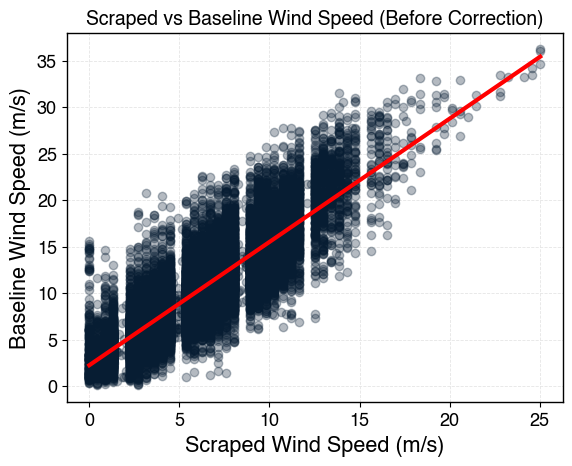

In [19]:
sns.regplot(
    data=ts_combined_2017,
    x='Scrape_wind_ms',
    y='Baseline_wind_ms',
    scatter_kws={'alpha': 0.3},
    line_kws={'color': 'red'},
)

plt.xlabel('Scraped Wind Speed (m/s)')
plt.ylabel('Baseline Wind Speed (m/s)')
plt.title('Scraped vs Baseline Wind Speed (Before Correction)')
plt.grid(True)
plt.show()


Since the scraped wind data consistently shows lower values over time compared to the baseline, this could be due to differences in measurement location, such as being recorded at a lower altitude or from a slightly different area in Orkney. Additionally, because the relationship between scraped and baseline wind speeds appears to be fairly linear, we can justify applying a linear regression model to correct the scraped data.

### Regression Model

In [20]:
# Drop rows with missing values for training
df_clean = ts_combined_2017.dropna(subset=['Scrape_wind_ms', 'Baseline_wind_ms'])

# Fit linear regression
X = df_clean[['Scrape_wind_ms']]
y = df_clean['Baseline_wind_ms'].values

model = LinearRegression()
model.fit(X, y)

# Apply model to full dataset (including rows with NaNs in baseline)
ts_combined_2017['Scrape_linear_scaled_wind_ms'] = np.nan  # initialize with NaNs
mask = ts_combined_2017['Scrape_wind_ms'].notna()
ts_combined_2017.loc[mask, 'Scrape_linear_scaled_wind_ms'] = model.predict(ts_combined_2017.loc[mask, ['Scrape_wind_ms']])

y_pred = model.predict(X)

mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = root_mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"Linear Regression Correction:")
print(f"MAE: {mae:.2f} m/s")
print(f"MSE: {mse:.2f} m²/s²")
print(f"RMSE: {rmse:.2f} m/s")
print(f"R² Score: {r2:.2f}")

print('')

baseline_mask = ts_combined_2017['Baseline_wind_ms'].notna() & ts_combined_2017['Scrape_wind_ms'].notna()

print(f'Baseline Error Metrics:')
print(f"MAE: {mean_absolute_error(ts_combined_2017.loc[baseline_mask, 'Baseline_wind_ms'], ts_combined_2017.loc[baseline_mask, 'Scrape_wind_ms']):.2f} m/s")
print(f"MSE: {mean_squared_error(ts_combined_2017.loc[baseline_mask, 'Baseline_wind_ms'], ts_combined_2017.loc[baseline_mask, 'Scrape_wind_ms']):.2f} m²/s²")
print(f"RMSE: {root_mean_squared_error(ts_combined_2017.loc[baseline_mask, 'Baseline_wind_ms'], ts_combined_2017.loc[baseline_mask, 'Scrape_wind_ms']):.2f} m/s")
print(f"R² Score: {r2_score(ts_combined_2017.loc[baseline_mask, 'Baseline_wind_ms'], ts_combined_2017.loc[baseline_mask, 'Scrape_wind_ms']):.2f}")


Linear Regression Correction:
MAE: 2.26 m/s
MSE: 8.56 m²/s²
RMSE: 2.92 m/s
R² Score: 0.71

Baseline Error Metrics:
MAE: 4.31 m/s
MSE: 27.70 m²/s²
RMSE: 5.26 m/s
R² Score: 0.05


The R² score increased from 0.05 to 0.71, which means the linear regression model explains 71% of the variance in the corrected wind speed values. The RMSE also dropped significantly, from 5.26 m/s to 2.92 m/s, indicating that the model provides much more accurate predictions.

We use linear regression in this case because it’s a simple and effective method for correcting systematic bias or scaling issues in sensor data. By fitting a straight line between the predicted and actual values, we can adjust the raw measurements to better reflect reality. This approach is especially useful when the relationship between the two variables is approximately linear, as it appears to be in this case.

---

## Data Cleaning & Filling Logic for Wind Power Dataset

### 1. **Filling Missing Wind Speed**

* **Primary source:** `Baseline_wind_ms`
* **Backup source:** `Scrape_linear_scaled_wind_ms`


- If Baseline_wind_ms is not missing:
    - Wind_ms = Baseline_wind_ms
    - Wind_data_source = "baseline"
- Else:
    - Wind_ms = Scrape_linear_scaled_wind_ms
    - Wind_data_source = "scraped"


A new column `Wind_data_source` is created to indicate the origin of the filled value (`"baseline"` or `"scraped"`).


In [21]:
ts_combined_2017['Final_wind_ms'] = ts_combined_2017['Baseline_wind_ms']
mask = ts_combined_2017['Baseline_wind_ms'].isna()

# Fill missing with corrected scraped wind
ts_combined_2017.loc[mask, 'Final_wind_ms'] = ts_combined_2017.loc[mask, 'Scrape_linear_scaled_wind_ms']

# Track data source
ts_combined_2017['Wind_data_source'] = 'baseline'
ts_combined_2017.loc[mask, 'Wind_data_source'] = 'scraped'

In [22]:
ts_combined_2017.head()

,Power_kw,Setpoint_kw,Baseline_wind_ms,Scrape_wind_ms,scraped_interpolated,baseline_interpolated,Scrape_linear_scaled_wind_ms,Final_wind_ms,Wind_data_source
Timestamp,,,,,,,,,
2017-01-01 00:00:00,889.766667,900.0,13.820000,10.28,True,False,15.871210,13.820000,baseline
2017-01-01 00:30:00,893.266667,900.0,16.106667,10.28,False,False,15.871210,16.106667,baseline
2017-01-01 01:00:00,897.633333,900.0,16.380000,9.39,False,False,14.691604,16.380000,baseline
2017-01-01 01:30:00,899.966667,900.0,17.083333,9.83,False,False,15.274780,17.083333,baseline
2017-01-01 02:00:00,900.000000,900.0,16.800000,7.15,False,False,11.722710,16.800000,baseline



### 2. **Filling Missing Power Values**

We address cases where the baseline power data is missing (`NaN`) and estimate it based on wind speed using a *delayed Weibull* function **only when appropriate**.

#### Rules:

* If wind speed is **missing**, we **know the data is missing**, so we assume it’s safe to estimate and calculate power using the delayed Weibull function.
* If wind speed is **below** `v_min`, power is naturally expected to be zero → we calculate it using the Weibull function (though it will return near-zero).
* If wind speed is **above** `v_min` and power is `NaN`, this might indicate it is purposely turned off (i.e. the turbine was in maintenance) → we **don't** calculate and leave it as `NaN`.

$$
P(\nu) = P_r \left(1 - e^{- \left(\frac{\nu - v_0}{c}\right)^3} \right)
$$

Where:

* $\nu$ = wind speed
* $v_0$ = minimum wind speed (`v_min`)
* $c$ = scale parameter
* $P_r$ = rated power


- If Power_baseline is not missing:
    - Power = Power_baseline
    - Power_data_source = "baseline"

- Else:
    - If Wind_ms is missing OR Wind_ms < v_min:
        - Power = Plugging wind data to delayed Weibull function:
        - Power_data_source = "scraped"
    - Else:
        - Power = NaN  # Wind is sufficient, but power is missing → likely curtailment
        - Power_data_source = "scraped"


A new column `Power_data_source` is created to indicate whether power was from:

* `"baseline"` → original data
* `"scraped"` → calculated using the Weibull function


In [23]:
# Calculate power output using the Weibull model
ts_combined_2017['Predicted_power_kw'] = delayed_weibull(ts_combined_2017['Final_wind_ms'], v0_fit, c_fit, pr=900)

# Turbine_power_kw initialize with baseline power
ts_combined_2017['Turbine_power_kw'] = ts_combined_2017['Power_kw']

# Define where it's safe to fill: no curtailment or shut-down
fill_mask = ts_combined_2017['Power_kw'].isna() & (
    ts_combined_2017['Baseline_wind_ms'].isna()   # can't assess → OK to fill
    # | (ts_combined_2017['Baseline_wind_ms'] < _v_cut_in)   # not enough wind
    # | (ts_combined_2017['Baseline_wind_ms'] > _v_cut_out)    # above cut-out (optional: derating)
)

# Fill with predicted power where appropriate
ts_combined_2017.loc[fill_mask, 'Turbine_power_kw'] = ts_combined_2017.loc[fill_mask, 'Predicted_power_kw']

# Add power data source flag
ts_combined_2017['Power_data_source'] = 'baseline'
ts_combined_2017.loc[fill_mask, 'Power_data_source'] = 'predicted'

ts_combined_2017.loc[
    ts_combined_2017['Power_kw'].isna() &
    (ts_combined_2017['Baseline_wind_ms'] > _v_cut_in),
    'Power_data_source'
] = 'not_operating'

ts_combined_2017.loc[
    ts_combined_2017['Power_kw'].isna() &
    ~ts_combined_2017['scraped_interpolated'] &
    ~ts_combined_2017['baseline_interpolated'],
    'Power_data_source'
] = 'not_available'

In [24]:
ts_combined_2017.head()

,Power_kw,Setpoint_kw,Baseline_wind_ms,Scrape_wind_ms,scraped_interpolated,baseline_interpolated,Scrape_linear_scaled_wind_ms,Final_wind_ms,Wind_data_source,Predicted_power_kw,Turbine_power_kw,Power_data_source
Timestamp,,,,,,,,,,,,
2017-01-01 00:00:00,889.766667,900.0,13.820000,10.28,True,False,15.871210,13.820000,baseline,861.484728,889.766667,baseline
2017-01-01 00:30:00,893.266667,900.0,16.106667,10.28,False,False,15.871210,16.106667,baseline,896.296908,893.266667,baseline
2017-01-01 01:00:00,897.633333,900.0,16.380000,9.39,False,False,14.691604,16.380000,baseline,897.363869,897.633333,baseline
2017-01-01 01:30:00,899.966667,900.0,17.083333,9.83,False,False,15.274780,17.083333,baseline,898.968514,899.966667,baseline
2017-01-01 02:00:00,900.000000,900.0,16.800000,7.15,False,False,11.722710,16.800000,baseline,898.477689,900.000000,baseline


# Power to Energy

$$
\boxed{\text{Energy (kWh)} = \text{Power (kW)} \times \text{Time (hours)}}
$$

We are going to convert the power measured in Kilowatt to energy (kilowatt per hour). However, since our data is in 30 minute interval we are going to multiply our power by 0.5

In [25]:
ts_combined_2017['Turbine_energy_kwh'] = ts_combined_2017['Turbine_power_kw'] * 0.5 # cause our data is 30 min

# Check for Final Missing Value

In [26]:
# check final NaN values
print(f'Final NaN values in Final_wind_ms: {ts_combined_2017["Final_wind_ms"].isna().sum()}')
print(f'Final NaN values in Turbine_power_kw: {ts_combined_2017["Turbine_power_kw"].isna().sum()}')


Final NaN values in Final_wind_ms: 16
Final NaN values in Turbine_power_kw: 61


In [27]:
# Check where turbine power is still NaN
ts_combined_2017[ts_combined_2017['Turbine_power_kw'].isna()].head()

,Power_kw,Setpoint_kw,Baseline_wind_ms,Scrape_wind_ms,scraped_interpolated,baseline_interpolated,Scrape_linear_scaled_wind_ms,Final_wind_ms,Wind_data_source,Predicted_power_kw,Turbine_power_kw,Power_data_source,Turbine_energy_kwh
Timestamp,,,,,,,,,,,,,
2017-01-12 18:00:00,NaN,900.0,23.556667,9.39,False,False,14.691604,23.556667,baseline,899.999999,NaN,not_available,NaN
2017-01-12 19:00:00,NaN,900.0,23.820000,12.52,False,False,18.840104,23.820000,baseline,899.999999,NaN,not_available,NaN
2017-01-12 19:30:00,NaN,900.0,26.503333,13.86,False,False,20.616139,26.503333,baseline,900.000000,NaN,not_available,NaN
2017-01-12 20:00:00,NaN,900.0,25.410000,14.31,False,False,21.212569,25.410000,baseline,900.000000,NaN,not_available,NaN
2017-01-12 21:30:00,NaN,900.0,25.470000,15.65,False,False,22.988604,25.470000,baseline,900.000000,NaN,not_available,NaN


In [28]:
# Check Where the missing value is
ts_combined_2017[ts_combined_2017['Final_wind_ms'].isna()].head()

,Power_kw,Setpoint_kw,Baseline_wind_ms,Scrape_wind_ms,scraped_interpolated,baseline_interpolated,Scrape_linear_scaled_wind_ms,Final_wind_ms,Wind_data_source,Predicted_power_kw,Turbine_power_kw,Power_data_source,Turbine_energy_kwh
Timestamp,,,,,,,,,,,,,
2017-04-07 22:30:00,NaN,NaN,NaN,NaN,False,False,NaN,NaN,scraped,0.0,0.0,not_available,0.0
2017-04-07 23:00:00,NaN,NaN,NaN,NaN,False,False,NaN,NaN,scraped,0.0,0.0,not_available,0.0
2017-04-07 23:30:00,NaN,NaN,NaN,NaN,False,False,NaN,NaN,scraped,0.0,0.0,not_available,0.0
2017-04-08 00:00:00,NaN,NaN,NaN,NaN,False,False,NaN,NaN,scraped,0.0,0.0,not_available,0.0
2017-04-08 00:30:00,NaN,NaN,NaN,NaN,False,False,NaN,NaN,scraped,0.0,0.0,not_available,0.0


---

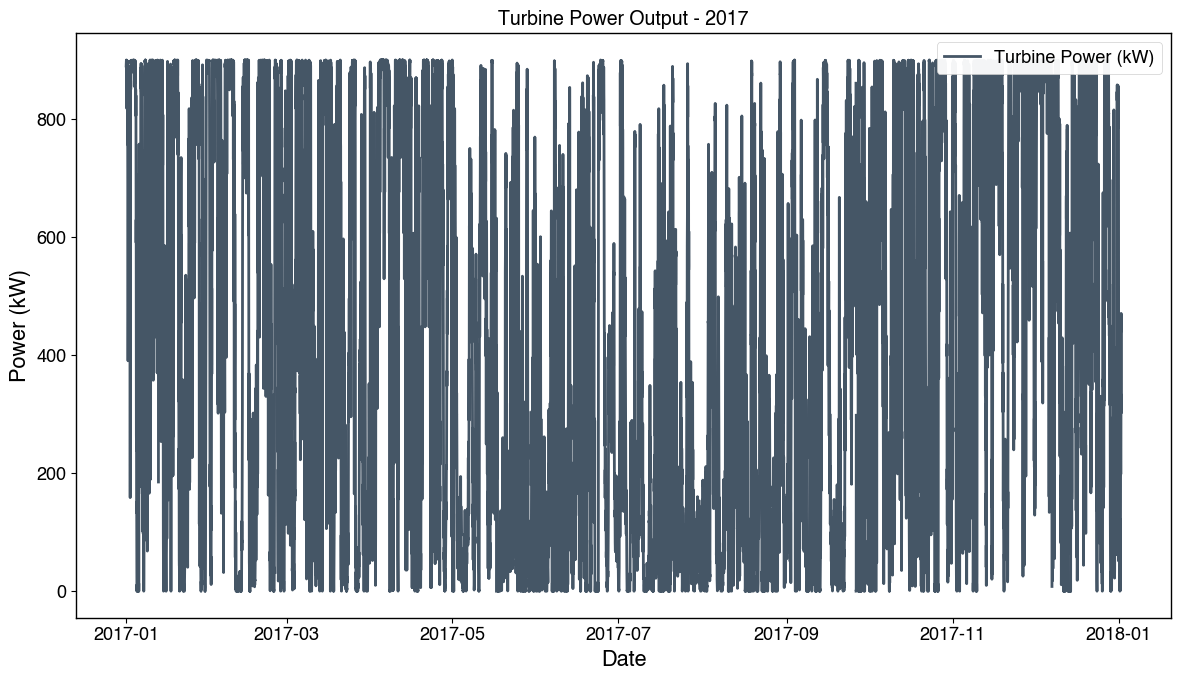

In [31]:
# Final plot power over time
plt.figure(figsize=(12, 7))
plt.plot(ts_combined_2017.index, ts_combined_2017['Turbine_power_kw'], label='Turbine Power (kW)', alpha=0.75)
plt.title('Turbine Power Output - 2017')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Exporting The Data

In [30]:
# rename columns for clarity
ts_renamed = ts_combined_2017.copy()
ts_renamed.rename(
    columns={
        'Power_kw': 'turbine_power_kw',
        'Setpoint_kw': 'turbine_setpoint_kw',
        'Baseline_wind_ms': 'wind_baseline_ms',
        'Scrape_wind_ms': 'wind_scraped_ms',
        'Scrape_linear_scaled_wind_ms': 'wind_scraped_scaled_ms',
        'scraped_interpolated': 'wind_scraped_is_interpolated',
        'baseline_interpolated': 'wind_baseline_is_interpolated',
        'Final_wind_ms': 'wind_final_ms',
        'Wind_data_source': 'wind_final_source',
        'Predicted_power_kw': 'turbine_power_predicted_kw',
        'Turbine_power_kw': 'turbine_power_final_kw',
        'Power_data_source': 'turbine_power_final_source',
        'Turbine_energy_kwh': 'turbine_energy_kwh'
    },
    inplace=True
)


In [31]:
ts_renamed.head()

,turbine_power_kw,turbine_setpoint_kw,wind_baseline_ms,wind_scraped_ms,wind_scraped_is_interpolated,wind_baseline_is_interpolated,wind_scraped_scaled_ms,wind_final_ms,wind_final_source,turbine_power_predicted_kw,turbine_power_final_kw,turbine_power_final_source,turbine_energy_kwh
Timestamp,,,,,,,,,,,,,
2017-01-01 00:00:00,889.766667,900.0,13.820000,10.28,True,False,15.871210,13.820000,baseline,861.484728,889.766667,baseline,444.883333
2017-01-01 00:30:00,893.266667,900.0,16.106667,10.28,False,False,15.871210,16.106667,baseline,896.296908,893.266667,baseline,446.633333
2017-01-01 01:00:00,897.633333,900.0,16.380000,9.39,False,False,14.691604,16.380000,baseline,897.363869,897.633333,baseline,448.816667
2017-01-01 01:30:00,899.966667,900.0,17.083333,9.83,False,False,15.274780,17.083333,baseline,898.968514,899.966667,baseline,449.983333
2017-01-01 02:00:00,900.000000,900.0,16.800000,7.15,False,False,11.722710,16.800000,baseline,898.477689,900.000000,baseline,450.000000


### Turbine & Wind Data — Final Column Dictionary

| Column Name                     | Data Type | Unit | Description                                                                          |
| ------------------------------- | --------- | ---- | ------------------------------------------------------------------------------------ |
| `turbine_power_kw`              | `float`   | kW   | Actual power output from the turbine (baseline telemetry).                           |
| `turbine_setpoint_kw`           | `float`   | kW   | Target or allowed power output set by the turbine controller or grid signal.         |
| `wind_baseline_ms`              | `float`   | m/s  | Measured wind speed from the turbine sensor (baseline).                              |
| `wind_scraped_ms`               | `float`   | m/s  | Wind speed scraped from a weather data source.                                       |
| `wind_scraped_scaled_ms`        | `float`   | m/s  | Scraped wind corrected using a linear regression model.                              |
| `wind_scraped_is_interpolated`  | `boolean` | -    | `True` if `wind_scraped_ms` was filled via short-gap interpolation.                  |
| `wind_baseline_is_interpolated` | `boolean` | -    | `True` if `wind_baseline_ms` was filled via short-gap interpolation.                 |
| `wind_final_ms`                 | `float`   | m/s  | Final selected wind speed (`wind_baseline_ms` or corrected `wind_scraped_ms`).       |
| `wind_final_source`             | `string`  | -    | Source of `wind_final_ms`: `"baseline"` or `"scraped"`.                              |
| `turbine_power_predicted_kw`    | `float`   | kW   | Power estimated from `wind_final_ms` using a Weibull power model.                    |
| `turbine_power_final_kw`        | `float`   | kW   | Final selected power: either `turbine_power_kw` or `turbine_power_predicted_kw`.     |
| `turbine_power_final_source`    | `string`  | -    | Source of `turbine_power_final_kw`: `"baseline"`, `"predicted"`, or `"not_operating"` or ,`"not_available"`. |
| `turbine_energy_kwh`            | `float`   | kWh  | Energy output during the 30-minute interval (`turbine_power_final_kw × 0.5`).        |


### Naming Convention Guidelines

* **snake\_case** is used for all column names for consistency.
* **Prefixes indicate variable context:**

  * `turbine_` → turbine-related power and energy metrics
  * `wind_` → wind speed data and sources
* **Suffixes indicate units or data type:**

  * `_kw` → kilowatts (power)
  * `_kwh` → kilowatt-hours (energy)
  * `_ms` → meters per second (wind speed)
  * `_is_interpolated` → boolean flags for interpolation
  * `_source` → categorical origin of data (e.g., `"baseline"`, `"scraped"`)
* Booleans use the structure `is_<status>` or `<context>_is_<status>` (e.g., `wind_scraped_is_interpolated`).


In [32]:
# Output the final DataFrame
ts_renamed.to_csv(PROCESSED_DATASET_PATH/'250411_turbine_telemetry_dataset_v1.csv', index=True)